In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from pyvis.network import Network
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)

In [2]:
data = pd.read_csv("variant_surveillance.tsv", sep = '\t',dtype = {'Variant': 'string',
                                                                 'Is reference?': 'string',
                                                                 'Is complete?': 'string'})
copy = data.copy()
data = data[data['Clade'].notna()]
data.head()

,Accession ID,Type,Clade,Pango lineage,Pangolin version,AA Substitutions,Variant,Collection date,Location,Host,Submission date,Is reference?,Is complete?,Is high coverage?,Is low coverage?,N-Content,GC-Content,Sequence length
0,EPI_ISL_10010236,betacoronavirus,GRA,BA.1.17,PANGO-v1.8,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V...",VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,2022-01-25,Oceania / Australia / Australian Capital Terri...,Human,2022-02-17,<NA>,True,NaN,NaN,NaN,0.379635,29747
1,EPI_ISL_10010227,betacoronavirus,GRA,BA.1.17,PLEARN-v1.8,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V...",VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,2022-01-25,Oceania / Australia / Australian Capital Terri...,Human,2022-02-17,<NA>,True,NaN,NaN,0.009446,0.379794,29747
2,EPI_ISL_10010232,betacoronavirus,GRA,BA.1.17,PLEARN-v1.8,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V...",VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,2022-01-25,Oceania / Australia / Australian Capital Terri...,Human,2022-02-17,<NA>,True,NaN,NaN,0.000134,0.379585,29747
3,EPI_ISL_3578085,betacoronavirus,GK,B.1.617.2,PLEARN-v1.8,"(N_D377Y,M_I82T,Spike_D950N,N_R203M,NSP12_G671...",VOC Delta GK (B.1.617.2+AY.*) first detected i...,2021-08-18,Europe / Turkey,Human,2021-08-23,<NA>,True,True,NaN,0.000101,0.379853,29754
4,EPI_ISL_10299251,betacoronavirus,GRA,BA.1,PLEARN-v1.8,"(NSP5_P132H,Spike_T95I,Spike_A67V,Spike_K417N,...",VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,2022-01-17,Europe / Germany / North Rhine-Westphalia,Human,2022-02-24,<NA>,True,NaN,NaN,0.048908,0.380371,29729


In [3]:
#specify strings for each continent
data.loc[data['Location'].str.contains('Oceania'), 'Location'] = 'Oceania'
data.loc[data['Location'].str.contains('Europe'), 'Location'] = 'Europe'
data.loc[data['Location'].str.contains('North America'), 'Location'] = 'North America'
data.loc[data['Location'].str.contains('South America'), 'Location'] = 'South America'
data.loc[data['Location'].str.contains('South Smerica'), 'Location'] = 'South America'
data.loc[data['Location'].str.contains('Africa'), 'Location'] = 'Africa'
data.loc[data['Location'].str.contains('Central Asia'), 'Location'] = 'Asia'
data.loc[data['Location'].str.contains('Asia'), 'Location'] = 'Asia'
data.loc[data['Location'].str.contains('USA'), 'Location'] = 'North America'

In [4]:
df = data.copy()

In [5]:
#clean dataset and change collection date to datetime object
df = df[['Clade', 'Location', 'Collection date']]
df['Collection date'] =  pd.to_datetime(df['Collection date'])
df.head()

,Clade,Location,Collection date
0,GRA,Oceania,2022-01-25
1,GRA,Oceania,2022-01-25
2,GRA,Oceania,2022-01-25
3,GK,Europe,2021-08-18
4,GRA,Europe,2022-01-17


In [6]:
#change data to weekly
df['Date'] =  df['Collection date'].dt.to_period('W')
df.head()

,Clade,Location,Collection date,Date
0,GRA,Oceania,2022-01-25,2022-01-24/2022-01-30
1,GRA,Oceania,2022-01-25,2022-01-24/2022-01-30
2,GRA,Oceania,2022-01-25,2022-01-24/2022-01-30
3,GK,Europe,2021-08-18,2021-08-16/2021-08-22
4,GRA,Europe,2022-01-17,2022-01-17/2022-01-23


In [7]:
df_weekly = df[(df['Collection date'] >= '2020-01-01') & (df['Collection date'] <='2022-05-31')].groupby(['Clade','Location', 'Date']).size().reset_index()
df_weekly['Date'] = df_weekly['Date'].astype(str)

In [8]:
df_weekly.columns = ['Clade','Location','Date','Freq']

In [9]:
tmp = df_weekly['Date'].str.split('/', expand=True)
tmp.head()

,0,1
0,2019-12-30,2020-01-05
1,2020-01-27,2020-02-02
2,2020-02-24,2020-03-01
3,2020-03-02,2020-03-08
4,2020-03-09,2020-03-15


In [10]:
#create new column with date in string format
df_weekly2= pd.merge(df_weekly, tmp.iloc[:,0], left_index=True, right_index=True)
df_weekly2.columns = ['Clade', 'Location', 'WY-str', 'Freq', 'Date']

df_weekly2['Date'] = pd.to_datetime(df_weekly2['Date'])
df_weekly2.sort_values(by='Date')
df_weekly2

,Clade,Location,WY-str,Freq,Date
0,G,Africa,2019-12-30/2020-01-05,64,2019-12-30
1,G,Africa,2020-01-27/2020-02-02,5,2020-01-27
2,G,Africa,2020-02-24/2020-03-01,9,2020-02-24
3,G,Africa,2020-03-02/2020-03-08,6,2020-03-02
4,G,Africa,2020-03-09/2020-03-15,20,2020-03-09
...,...,...,...,...,...
5143,V,South America,2020-05-18/2020-05-24,2,2020-05-18
5144,V,South America,2020-05-25/2020-05-31,1,2020-05-25
5145,V,South America,2020-11-23/2020-11-29,1,2020-11-23
5146,V,South America,2021-02-15/2021-02-21,1,2021-02-15


In [11]:
#calculate weekly sums
df_weekly_sum = df_weekly.groupby(['Clade','Date','Location'], as_index=False)['Freq'].sum()
df_weekly_sum

,Clade,Date,Location,Freq
0,G,2019-12-30/2020-01-05,Africa,64
1,G,2019-12-30/2020-01-05,Asia,110
2,G,2019-12-30/2020-01-05,Europe,593
3,G,2019-12-30/2020-01-05,North America,58
4,G,2019-12-30/2020-01-05,Oceania,75
...,...,...,...,...
5143,V,2021-04-19/2021-04-25,North America,1
5144,V,2021-07-19/2021-07-25,North America,1
5145,V,2021-10-18/2021-10-24,North America,1
5146,V,2021-11-15/2021-11-21,Asia,3


In [12]:
df_weekly_na = df_weekly_sum[df_weekly_sum['Location'] == 'North America']
df_weekly_na

,Clade,Date,Location,Freq
3,G,2019-12-30/2020-01-05,North America,58
12,G,2020-01-27/2020-02-02,North America,1
21,G,2020-02-24/2020-03-01,North America,197
26,G,2020-03-02/2020-03-08,North America,35
32,G,2020-03-09/2020-03-15,North America,264
...,...,...,...,...
5140,V,2021-03-15/2021-03-21,North America,1
5143,V,2021-04-19/2021-04-25,North America,1
5144,V,2021-07-19/2021-07-25,North America,1
5145,V,2021-10-18/2021-10-24,North America,1


In [13]:
#pivot dataframe so that index is date and columns are clades
df_weekly_na = df_weekly_na.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
df_weekly_na = df_weekly_na.reset_index()
df_weekly_na

Clade,Date,G,GH,GK,GR,GRA,GRY,GV,L,O,S,V
0,2019-12-30/2020-01-05,58.0,460.0,NaN,29.0,2.0,9.0,NaN,4.0,4.0,4.0,NaN
1,2020-01-13/2020-01-19,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2,2020-01-20/2020-01-26,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,NaN
3,2020-01-27/2020-02-02,1.0,5.0,NaN,NaN,NaN,NaN,NaN,6.0,5.0,2.0,NaN
4,2020-02-03/2020-02-09,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
121,2022-05-02/2022-05-08,18.0,NaN,NaN,212.0,37513.0,NaN,NaN,NaN,10.0,NaN,NaN
122,2022-05-09/2022-05-15,28.0,NaN,3.0,189.0,39536.0,NaN,NaN,NaN,19.0,NaN,NaN
123,2022-05-16/2022-05-22,10.0,NaN,1.0,176.0,35336.0,NaN,NaN,NaN,38.0,NaN,NaN
124,2022-05-23/2022-05-29,2.0,NaN,2.0,96.0,26538.0,NaN,NaN,1.0,46.0,NaN,NaN


In [14]:
df_weekly_na['Collection date'] = np.random.randint(1,6,df_weekly_na.shape[0])
df_weekly_na

Clade,Date,G,GH,GK,GR,GRA,GRY,GV,L,O,S,V,Collection date
0,2019-12-30/2020-01-05,58.0,460.0,NaN,29.0,2.0,9.0,NaN,4.0,4.0,4.0,NaN,3
1,2020-01-13/2020-01-19,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1
2,2020-01-20/2020-01-26,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,NaN,1
3,2020-01-27/2020-02-02,1.0,5.0,NaN,NaN,NaN,NaN,NaN,6.0,5.0,2.0,NaN,3
4,2020-02-03/2020-02-09,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2022-05-02/2022-05-08,18.0,NaN,NaN,212.0,37513.0,NaN,NaN,NaN,10.0,NaN,NaN,5
122,2022-05-09/2022-05-15,28.0,NaN,3.0,189.0,39536.0,NaN,NaN,NaN,19.0,NaN,NaN,2
123,2022-05-16/2022-05-22,10.0,NaN,1.0,176.0,35336.0,NaN,NaN,NaN,38.0,NaN,NaN,2
124,2022-05-23/2022-05-29,2.0,NaN,2.0,96.0,26538.0,NaN,NaN,1.0,46.0,NaN,NaN,4


In [15]:
#split date column so we can retrieve month and year
tmp = df_weekly_na['Date'].str.rsplit('-',n=3, expand = True)
tmp.columns = ['0','1','2','3']
tmp

,0,1,2,3
0,2019-12,30/2020,01,05
1,2020-01,13/2020,01,19
2,2020-01,20/2020,01,26
3,2020-01,27/2020,02,02
4,2020-02,03/2020,02,09
...,...,...,...,...
121,2022-05,02/2022,05,08
122,2022-05,09/2022,05,15
123,2022-05,16/2022,05,22
124,2022-05,23/2022,05,29


In [16]:
#collection date column contains month and year of each week 
df_weekly_na['Collection date'] = tmp['0']
df_weekly_na = df_weekly_na[['Date','Collection date','G',
                             'GH','GK','GR','GRA','GRY','GV',
                             'L','O','S','V']]
df_weekly_na

Clade,Date,Collection date,G,GH,GK,GR,GRA,GRY,GV,L,O,S,V
0,2019-12-30/2020-01-05,2019-12,58.0,460.0,NaN,29.0,2.0,9.0,NaN,4.0,4.0,4.0,NaN
1,2020-01-13/2020-01-19,2020-01,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2,2020-01-20/2020-01-26,2020-01,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,NaN
3,2020-01-27/2020-02-02,2020-01,1.0,5.0,NaN,NaN,NaN,NaN,NaN,6.0,5.0,2.0,NaN
4,2020-02-03/2020-02-09,2020-02,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2022-05-02/2022-05-08,2022-05,18.0,NaN,NaN,212.0,37513.0,NaN,NaN,NaN,10.0,NaN,NaN
122,2022-05-09/2022-05-15,2022-05,28.0,NaN,3.0,189.0,39536.0,NaN,NaN,NaN,19.0,NaN,NaN
123,2022-05-16/2022-05-22,2022-05,10.0,NaN,1.0,176.0,35336.0,NaN,NaN,NaN,38.0,NaN,NaN
124,2022-05-23/2022-05-29,2022-05,2.0,NaN,2.0,96.0,26538.0,NaN,NaN,1.0,46.0,NaN,NaN


In [17]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['G','GH','GK','GR','GRA','GRY','GV','L','O','S','V']
VOC = ['GH','GK','GR','GRA','GRY']

clade_input = VOC

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    distance_matrix = pd.DataFrame(index = clade_input)
    distance_matrix[clade_input] = np.nan
    #fill in distance matrix
    for i in clade_input:
        for j in clade_input:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    difference_matrix = pd.DataFrame(index = clade_input)
    difference_matrix[clade_input] = np.nan
    #fill in difference matrix
    for i in clade_input:
        for j in clade_input:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Clade'] == '{a}vs{b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df,time_window):
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    return dataframe

def time_frame_no_cumsum(df,time_window):
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, clade_input):
    par = np.polyfit(day, clade_input, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(dataframe):
    dataframe['date_ordinal'] = pd.to_datetime(dataframe['Date']).apply(lambda date: date.toordinal())
    dataframe['days'] = dataframe['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_input:
        for j in clade_input:
            if i != j:
                dataframe['{a}vs{b}'.format(a=i,b=j)] = dataframe.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    dataframe = dataframe.drop(['G', 'GH', 'GK', 'GR', 'GRA', 'GRY', 'GV', 'L', 'O', 'S','V','date_ordinal'], axis=1)
    return dataframe

# North America

In [18]:
#specify time frame to analyze
df_na_sum = time_frame(df_weekly_na,['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05'])
df_na_sum.head()

Clade,Date,Collection date,G,GH,GK,GR,GRA,GRY,GV,L,O,S,V
95,2021-11-01/2021-11-07,2021-11,1677.0,110.0,70999.0,27.0,7.0,4.0,90.0,20.0,808.0,2.0,NaN
96,2021-11-08/2021-11-14,2021-11,3028.0,233.0,135948.0,43.0,18.0,6.0,134.0,57.0,1780.0,NaN,NaN
97,2021-11-15/2021-11-21,2021-11,4379.0,369.0,197693.0,57.0,30.0,7.0,172.0,85.0,2945.0,NaN,NaN
98,2021-11-22/2021-11-28,2021-11,6035.0,492.0,248203.0,72.0,139.0,9.0,225.0,95.0,3408.0,NaN,NaN
99,2021-11-29/2021-12-05,2021-11,8090.0,644.0,321456.0,93.0,2145.0,14.0,266.0,99.0,4267.0,NaN,NaN


In [19]:
#calculate log comparisons at each week
df_na = clade_comparisons(df_na_sum)
df_na['days'] -= df_na['days'].iloc[0]
df_na.head()

Clade,Date,Collection date,days,GHvsGK,GHvsGR,GHvsGRA,GHvsGRY,GKvsGH,GKvsGR,GKvsGRA,...,GRvsGRA,GRvsGRY,GRAvsGH,GRAvsGK,GRAvsGR,GRAvsGRY,GRYvsGH,GRYvsGK,GRYvsGR,GRYvsGRA
95,2021-11-01/2021-11-07,2021-11,0,-2.809860,0.610029,1.196295,1.439333,2.809860,3.419888,4.006154,...,0.586266,0.829304,-1.196295,-4.006154,-0.586266,0.243038,-1.439333,-4.249192,-0.829304,-0.243038
96,2021-11-08/2021-11-14,2021-11,7,-2.766017,0.733887,1.112083,1.589205,2.766017,3.499904,3.878100,...,0.378196,0.855317,-1.112083,-3.878100,-0.378196,0.477121,-1.589205,-4.355222,-0.855317,-0.477121
97,2021-11-15/2021-11-21,2021-11,14,-2.728965,0.811152,1.089905,1.721928,2.728965,3.540116,3.818870,...,0.278754,0.910777,-1.089905,-3.818870,-0.278754,0.632023,-1.721928,-4.450893,-0.910777,-0.632023
98,2021-11-22/2021-11-28,2021-11,21,-2.702842,0.834633,0.548950,1.737723,2.702842,3.537475,3.251792,...,-0.285682,0.903090,-0.548950,-3.251792,0.285682,1.188772,-1.737723,-4.440565,-0.903090,-1.188772
99,2021-11-29/2021-12-05,2021-11,28,-2.698236,0.840403,-0.522541,1.662758,2.698236,3.538639,2.175694,...,-1.362944,0.822355,0.522541,-2.175694,1.362944,2.185299,-1.662758,-4.360994,-0.822355,-2.185299


In [20]:
#calculate slopes, have to disregard nans
df_na_slopes = pd.DataFrame()
cols = df_na.columns.to_list()
df_na_slopes['Clade'] = cols[3:]
slopes = []
for i,v in enumerate(df_na.iloc[:,3:]):
    tmp = df_na[~df_na.iloc[:,i+3].isnull()]
    tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
    slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
    
df_na_slopes['Slope'] = slopes
tmp.head()

Clade,Date,Collection date,days,GHvsGK,GHvsGR,GHvsGRA,GHvsGRY,GKvsGH,GKvsGR,GKvsGRA,...,GRvsGRY,GRAvsGH,GRAvsGK,GRAvsGR,GRAvsGRY,GRYvsGH,GRYvsGK,GRYvsGR,GRYvsGRA,pseudo_time
95,2021-11-01/2021-11-07,2021-11,0,-2.809860,0.610029,1.196295,1.439333,2.809860,3.419888,4.006154,...,0.829304,-1.196295,-4.006154,-0.586266,0.243038,-1.439333,-4.249192,-0.829304,-0.243038,0
96,2021-11-08/2021-11-14,2021-11,7,-2.766017,0.733887,1.112083,1.589205,2.766017,3.499904,3.878100,...,0.855317,-1.112083,-3.878100,-0.378196,0.477121,-1.589205,-4.355222,-0.855317,-0.477121,7
97,2021-11-15/2021-11-21,2021-11,14,-2.728965,0.811152,1.089905,1.721928,2.728965,3.540116,3.818870,...,0.910777,-1.089905,-3.818870,-0.278754,0.632023,-1.721928,-4.450893,-0.910777,-0.632023,14
98,2021-11-22/2021-11-28,2021-11,21,-2.702842,0.834633,0.548950,1.737723,2.702842,3.537475,3.251792,...,0.903090,-0.548950,-3.251792,0.285682,1.188772,-1.737723,-4.440565,-0.903090,-1.188772,21
99,2021-11-29/2021-12-05,2021-11,28,-2.698236,0.840403,-0.522541,1.662758,2.698236,3.538639,2.175694,...,0.822355,0.522541,-2.175694,1.362944,2.185299,-1.662758,-4.360994,-0.822355,-2.185299,28


In [24]:
dist_mat_na = create_distance_matrix(df_na_slopes,'Slope')
dif_mat_na = create_difference_matrix(df_na_slopes,'Slope')
dist_mat_na

,GH,GK,GR,GRA,GRY
GH,0.000000,0.000925,0.006668,0.031093,0.002211
GK,0.000925,0.000000,0.006425,0.019593,0.000602
GR,0.006668,0.006425,0.000000,0.011446,0.014145
GRA,0.031093,0.019593,0.011446,0.000000,0.069841
GRY,0.002211,0.000602,0.014145,0.069841,0.000000


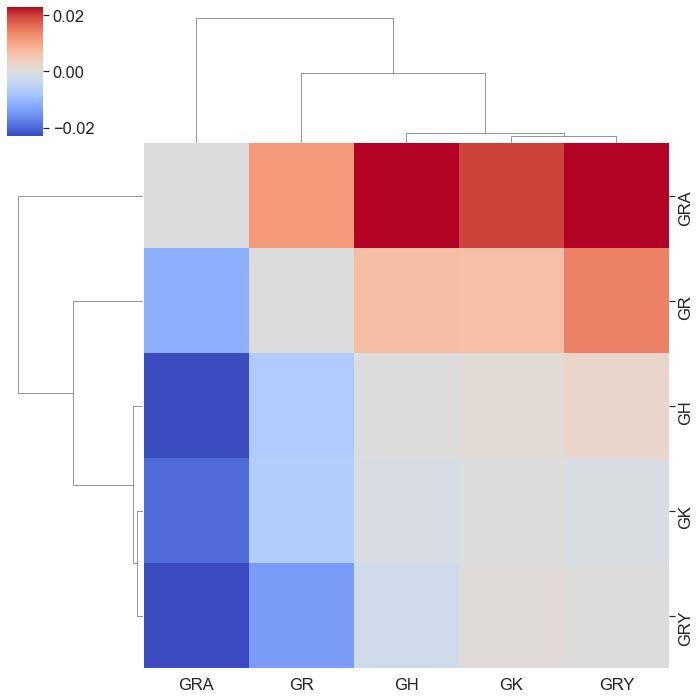

In [46]:
#Plot distance matrix as clustermap
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

#create distance array from distance matrix
distance_array = ssd.squareform(dist_mat_na) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)

#display clustermap
g = sns.clustermap(dif_mat_na, row_linkage=distance_linkage, col_linkage=distance_linkage,
               cmap = 'coolwarm',vmin=-.023,vmax=0.023)


Text(0.5, 1.0, 'GRA vs Clades Containing VOC')

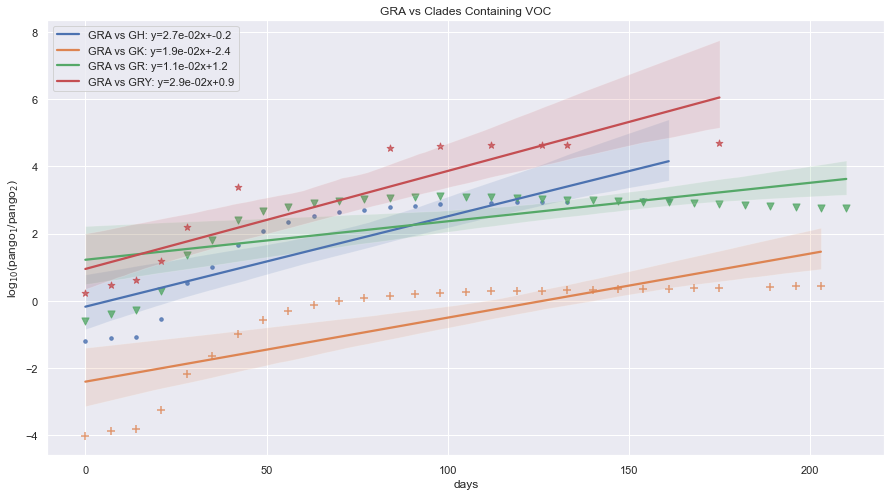

In [27]:
#scatterplot of GRA clade fitness
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
legend = []
marker = ['.', '+', 'v', 'x','*']
c=0
for i in clade_input:
    if i != 'GRA':
        mask = ~np.isnan(df_na['days']) & ~np.isnan(df_na['GRAvs{a}'.format(a=i)])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_na['days'][mask],df_na['GRAvs{a}'.format(a=i)][mask])
        sns.regplot(x = df_na['days'], y = df_na['GRAvs{a}'.format(a=i)], marker = marker[c],scatter_kws={'s':50})
        legend.append('GRA vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
    c+=1
plt.legend(legend, loc='upper left')
plt.ylabel(r'log$_1$$_0$(pango$_1$/pango$_2$)')
plt.title('GRA vs Clades Containing VOC')

# Europe

In [28]:
df_weekly_eu = df_weekly_sum[df_weekly_sum['Location'] == 'Europe']
#pivot dataframe so that index is date and columns are clades
df_weekly_eu = df_weekly_eu.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
df_weekly_eu = df_weekly_eu.reset_index()
df_weekly_eu['Collection date'] = np.random.randint(1,6,df_weekly_eu.shape[0])
#split date column so we can retrieve month and year
tmp = df_weekly_eu['Date'].str.rsplit('-',n=3, expand = True)
tmp.columns = ['0','1','2','3']
#collection date column contains month and year of each week 
df_weekly_eu['Collection date'] = tmp['0']
df_weekly_eu = df_weekly_eu[['Date','Collection date','G',
                             'GH','GK','GR','GRA','GRY','GV',
                             'L','O','S','V']]

In [29]:
#specify time frame to analyze
df_eu_sum = time_frame(df_weekly_eu,['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05'])
#calculate log comparisons at each week
df_eu = clade_comparisons(df_eu_sum)
df_eu['days'] -= df_eu['days'].iloc[0]
#calculate slopes, have to disregard nans
df_eu_slopes = pd.DataFrame()
cols = df_eu.columns.to_list()
df_eu_slopes['Clade'] = cols[3:]
slopes = []
for i,v in enumerate(df_eu.iloc[:,3:]):
    tmp = df_eu[~df_eu.iloc[:,i+3].isnull()]
    tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
    slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
    
df_eu_slopes['Slope'] = slopes
dist_mat_eu = create_distance_matrix(df_eu_slopes,'Slope')
dif_mat_eu = create_difference_matrix(df_eu_slopes,'Slope')

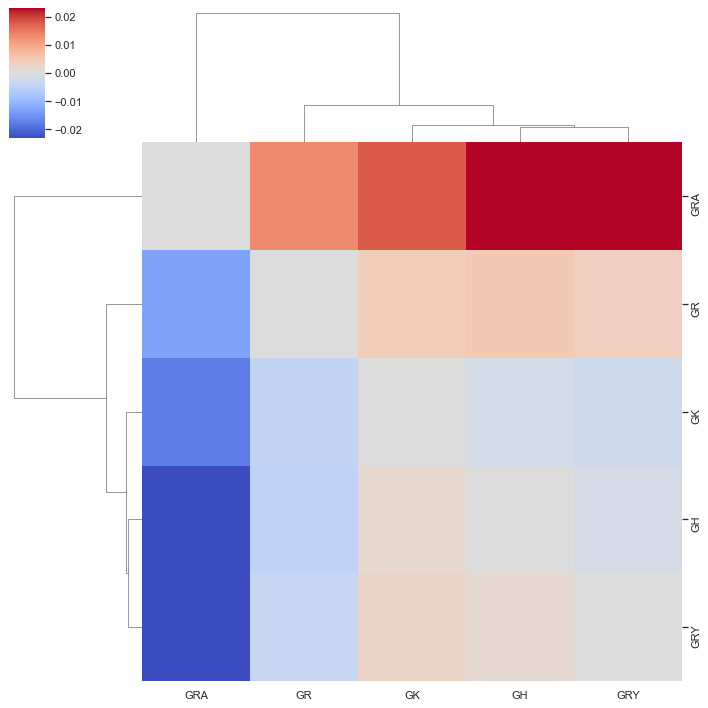

In [31]:
#Plot distance matrix as clustermap
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

#create distance array from distance matrix
distance_array = ssd.squareform(dist_mat_eu) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)

#display clustermap
g = sns.clustermap(dif_mat_eu, row_linkage=distance_linkage, col_linkage=distance_linkage,
               cmap = 'coolwarm',vmin=-.023,vmax=0.023)

Text(0.5, 1.0, 'GRA vs Clades Containing VOC')

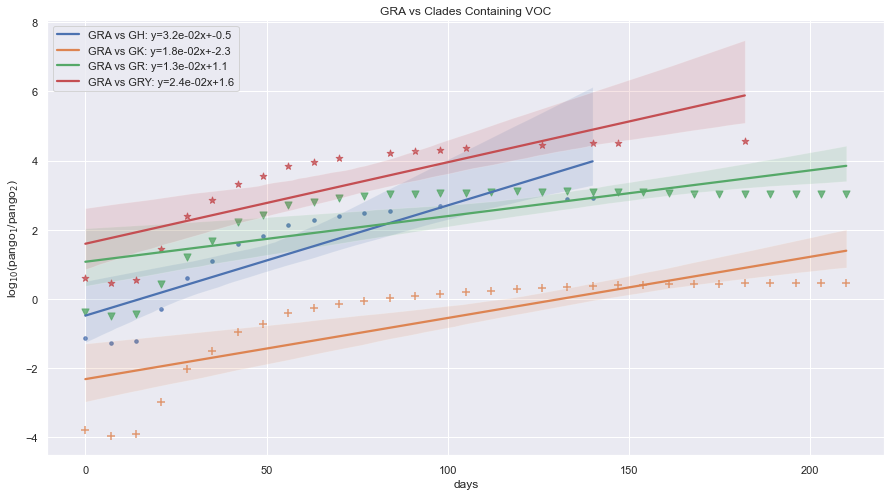

In [32]:
#scatterplot of GRA clade fitness
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
legend = []
marker = ['.', '+', 'v', 'x','*']
c=0
for i in clade_input:
    if i != 'GRA':
        mask = ~np.isnan(df_eu['days']) & ~np.isnan(df_eu['GRAvs{a}'.format(a=i)])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_eu['days'][mask],df_eu['GRAvs{a}'.format(a=i)][mask])
        sns.regplot(x = df_eu['days'], y = df_eu['GRAvs{a}'.format(a=i)], marker = marker[c],scatter_kws={'s':50})
        legend.append('GRA vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
    c+=1
plt.legend(legend, loc='upper left')
plt.ylabel(r'log$_1$$_0$(pango$_1$/pango$_2$)')
plt.title('GRA vs Clades Containing VOC')

# Asia

In [33]:
df_weekly_as = df_weekly_sum[df_weekly_sum['Location'] == 'Asia']
#pivot dataframe so that index is date and columns are clades
df_weekly_as = df_weekly_as.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
df_weekly_as = df_weekly_as.reset_index()
df_weekly_as['Collection date'] = np.random.randint(1,6,df_weekly_as.shape[0])
#split date column so we can retrieve month and year
tmp = df_weekly_as['Date'].str.rsplit('-',n=3, expand = True)
tmp.columns = ['0','1','2','3']
#collection date column contains month and year of each week 
df_weekly_as['Collection date'] = tmp['0']
df_weekly_as = df_weekly_as[['Date','Collection date','G',
                             'GH','GK','GR','GRA','GRY','GV',
                             'L','O','S','V']]

In [36]:
#specify time frame to analyze
df_as_sum = time_frame(df_weekly_as,['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05'])
#calculate log comparisons at each week
df_as = clade_comparisons(df_as_sum)
df_as['days'] -= df_as['days'].iloc[0]
#calculate slopes, have to disregard nans
df_as_slopes = pd.DataFrame()
cols = df_as.columns.to_list()
df_as_slopes['Clade'] = cols[3:]
slopes = []
for i,v in enumerate(df_as.iloc[:,3:]):
    tmp = df_as[~df_as.iloc[:,i+3].isnull()]
    tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
    slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
    
df_as_slopes['Slope'] = slopes
dist_mat_as = create_distance_matrix(df_as_slopes,'Slope')
dif_mat_as = create_difference_matrix(df_as_slopes,'Slope')

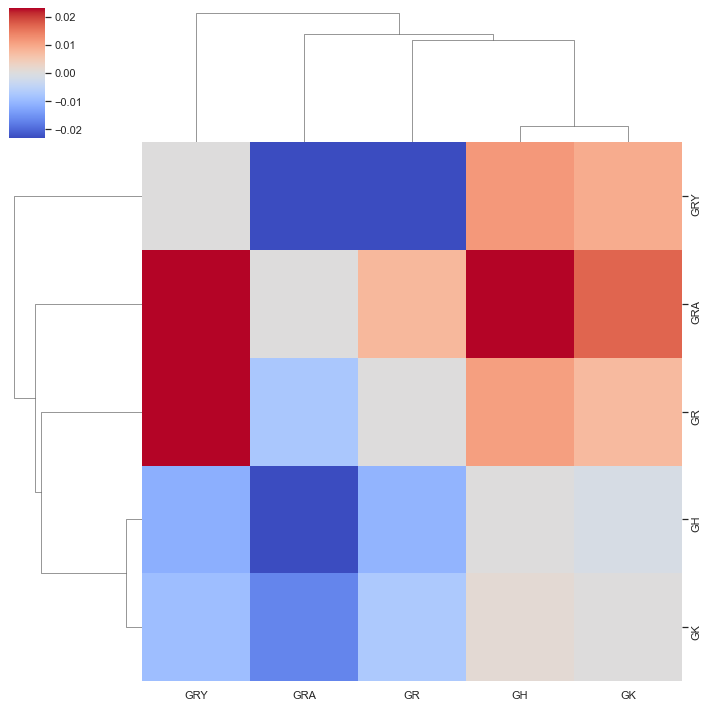

In [37]:
#Plot distance matrix as clustermap
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

#create distance array from distance matrix
distance_array = ssd.squareform(dist_mat) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)

#display clustermap
g = sns.clustermap(dif_mat_as, row_linkage=distance_linkage, col_linkage=distance_linkage,
               cmap = 'coolwarm',vmin=-.023,vmax=0.023)

Text(0.5, 1.0, 'GRA vs Clades Containing VOC')

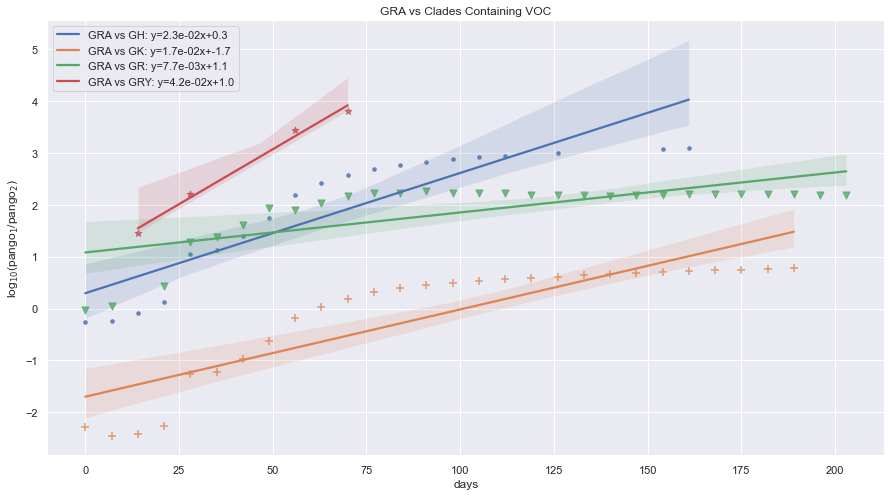

In [38]:
#scatterplot of GRA clade fitness
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
legend = []
marker = ['.', '+', 'v', 'x','*']
c=0
for i in clade_input:
    if i != 'GRA':
        mask = ~np.isnan(df_as['days']) & ~np.isnan(df_as['GRAvs{a}'.format(a=i)])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_as['days'][mask],df_as['GRAvs{a}'.format(a=i)][mask])
        sns.regplot(x = df_as['days'], y = df_as['GRAvs{a}'.format(a=i)], marker = marker[c],scatter_kws={'s':50})
        legend.append('GRA vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
    c+=1
plt.legend(legend, loc='upper left')
plt.ylabel(r'log$_1$$_0$(pango$_1$/pango$_2$)')
plt.title('GRA vs Clades Containing VOC')

# South America

In [39]:
df_weekly_sa = df_weekly_sum[df_weekly_sum['Location'] == 'South America']
#pivot dataframe so that index is date and columns are clades
df_weekly_sa = df_weekly_sa.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
df_weekly_sa = df_weekly_sa.reset_index()
df_weekly_sa['Collection date'] = np.random.randint(1,6,df_weekly_sa.shape[0])
#split date column so we can retrieve month and year
tmp = df_weekly_sa['Date'].str.rsplit('-',n=3, expand = True)
tmp.columns = ['0','1','2','3']
#collection date column contains month and year of each week 
df_weekly_sa['Collection date'] = tmp['0']
df_weekly_sa = df_weekly_sa[['Date','Collection date','G',
                             'GH','GK','GR','GRA','GRY','GV',
                             'L','O','S','V']]

In [40]:
#specify time frame to analyze
df_sa_sum = time_frame(df_weekly_sa,['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05'])
#calculate log comparisons at each week
df_sa = clade_comparisons(df_sa_sum)
df_sa['days'] -= df_sa['days'].iloc[0]
#calculate slopes, have to disregard nans
df_sa_slopes = pd.DataFrame()
cols = df_sa.columns.to_list()
df_sa_slopes['Clade'] = cols[3:]
slopes = []
for i,v in enumerate(df_sa.iloc[:,3:]):
    tmp = df_sa[~df_sa.iloc[:,i+3].isnull()]
    tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
    slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
    
df_sa_slopes['Slope'] = slopes
dist_mat_sa = create_distance_matrix(df_sa_slopes,'Slope')
dif_mat_sa = create_difference_matrix(df_sa_slopes,'Slope')

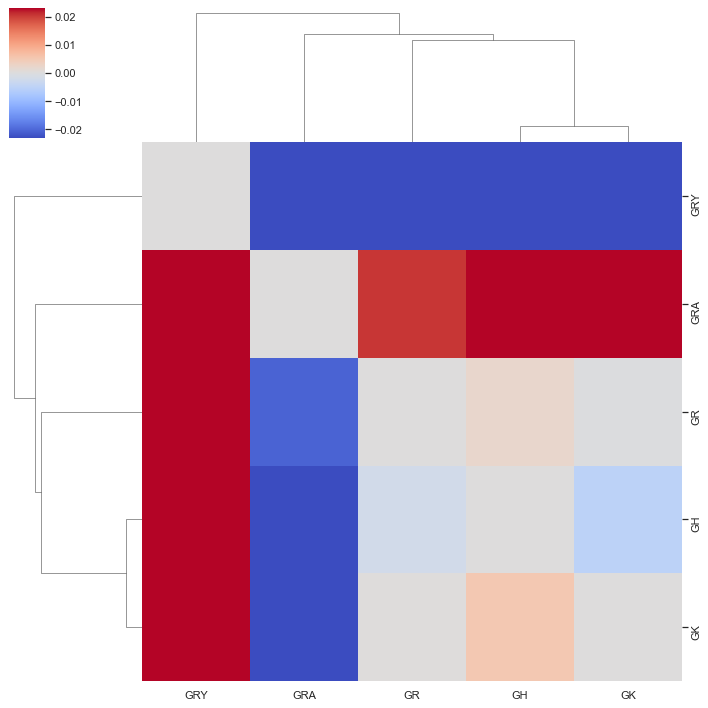

In [41]:
#Plot distance matrix as clustermap
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

#create distance array from distance matrix
distance_array = ssd.squareform(dist_mat) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)

#display clustermap
g = sns.clustermap(dif_mat_sa, row_linkage=distance_linkage, col_linkage=distance_linkage,
               cmap = 'coolwarm',vmin=-.023,vmax=0.023)

Text(0.5, 1.0, 'GRA vs Clades Containing VOC')

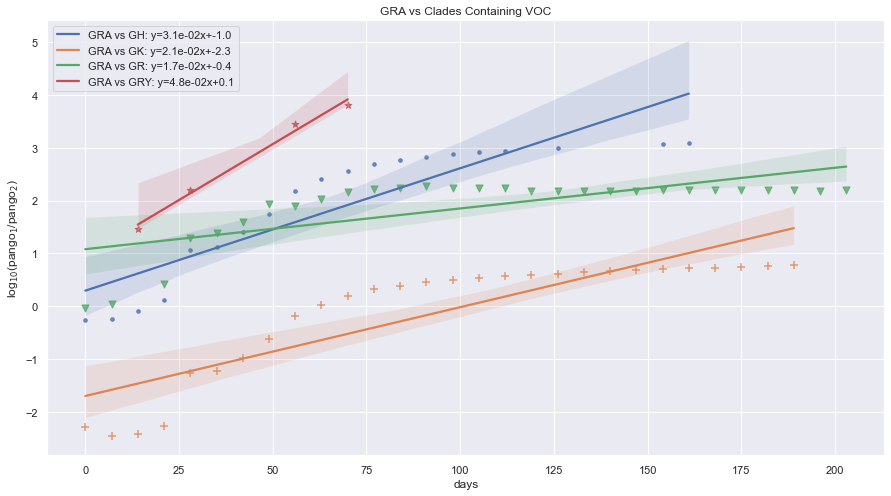

In [43]:
#scatterplot of GRA clade fitness
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
legend = []
marker = ['.', '+', 'v', 'x','*']
c=0
for i in clade_input:
    if i != 'GRA':
        mask = ~np.isnan(df_sa['days']) & ~np.isnan(df_sa['GRAvs{a}'.format(a=i)])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_sa['days'][mask],df_sa['GRAvs{a}'.format(a=i)][mask])
        sns.regplot(x = df_as['days'], y = df_as['GRAvs{a}'.format(a=i)], marker = marker[c],scatter_kws={'s':50})
        legend.append('GRA vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
    c+=1
plt.legend(legend, loc='upper left')
plt.ylabel(r'log$_1$$_0$(pango$_1$/pango$_2$)')
plt.title('GRA vs Clades Containing VOC')

# Oceania

In [47]:
df_weekly_sa = df_weekly_sum[df_weekly_sum['Location'] == 'South America']
#pivot dataframe so that index is date and columns are clades
df_weekly_sa = df_weekly_sa.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
df_weekly_sa = df_weekly_sa.reset_index()
df_weekly_sa['Collection date'] = np.random.randint(1,6,df_weekly_sa.shape[0])
#split date column so we can retrieve month and year
tmp = df_weekly_sa['Date'].str.rsplit('-',n=3, expand = True)
tmp.columns = ['0','1','2','3']
#collection date column contains month and year of each week 
df_weekly_sa['Collection date'] = tmp['0']
df_weekly_sa = df_weekly_sa[['Date','Collection date','G',
                             'GH','GK','GR','GRA','GRY','GV',
                             'L','O','S','V']]

In [48]:
#specify time frame to analyze
df_sa_sum = time_frame(df_weekly_sa,['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05'])
#calculate log comparisons at each week
df_sa = clade_comparisons(df_sa_sum)
df_sa['days'] -= df_sa['days'].iloc[0]
#calculate slopes, have to disregard nans
df_sa_slopes = pd.DataFrame()
cols = df_sa.columns.to_list()
df_sa_slopes['Clade'] = cols[3:]
slopes = []
for i,v in enumerate(df_sa.iloc[:,3:]):
    tmp = df_sa[~df_sa.iloc[:,i+3].isnull()]
    tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
    slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
    
df_sa_slopes['Slope'] = slopes
dist_mat_sa = create_distance_matrix(df_sa_slopes,'Slope')
dif_mat_sa = create_difference_matrix(df_sa_slopes,'Slope')

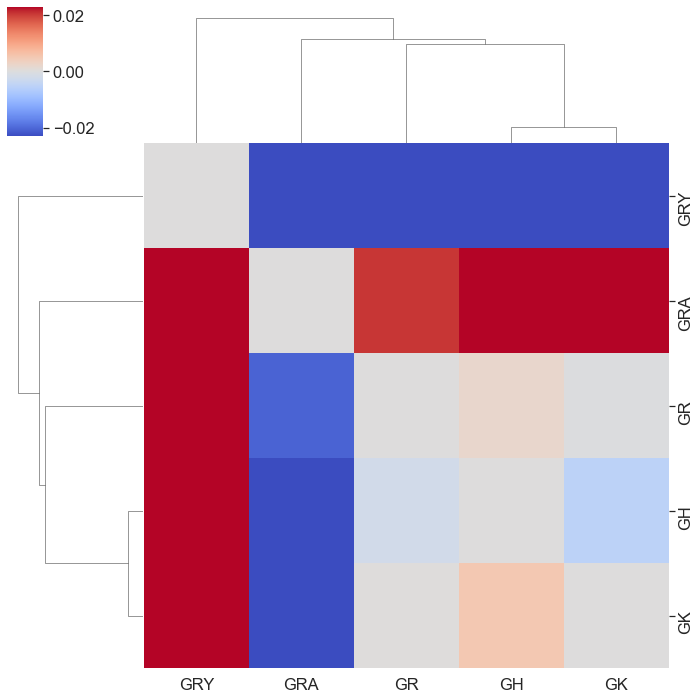

In [49]:
#Plot distance matrix as clustermap
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

#create distance array from distance matrix
distance_array = ssd.squareform(dist_mat) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)

#display clustermap
g = sns.clustermap(dif_mat_sa, row_linkage=distance_linkage, col_linkage=distance_linkage,
               cmap = 'coolwarm',vmin=-.023,vmax=0.023)

Text(0.5, 1.0, 'GRA vs Clades Containing VOC')

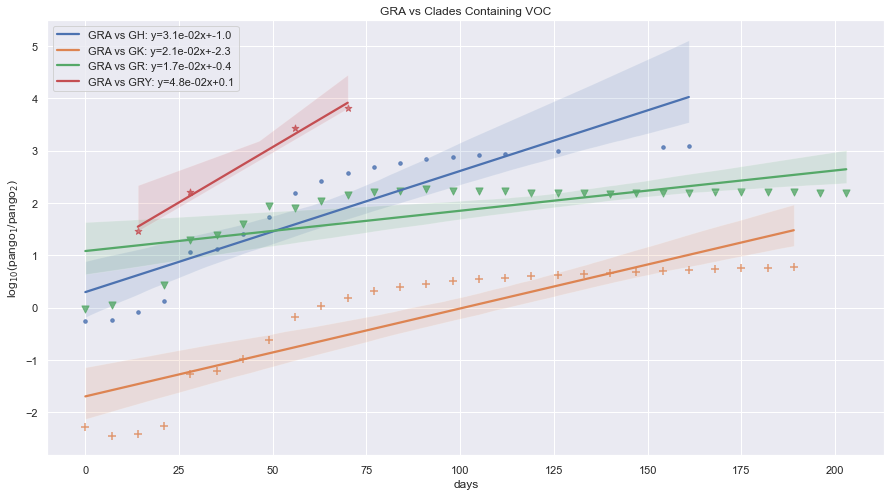

In [50]:
#scatterplot of GRA clade fitness
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
legend = []
marker = ['.', '+', 'v', 'x','*']
c=0
for i in clade_input:
    if i != 'GRA':
        mask = ~np.isnan(df_sa['days']) & ~np.isnan(df_sa['GRAvs{a}'.format(a=i)])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_sa['days'][mask],df_sa['GRAvs{a}'.format(a=i)][mask])
        sns.regplot(x = df_as['days'], y = df_as['GRAvs{a}'.format(a=i)], marker = marker[c],scatter_kws={'s':50})
        legend.append('GRA vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
    c+=1
plt.legend(legend, loc='upper left')
plt.ylabel(r'log$_1$$_0$(pango$_1$/pango$_2$)')
plt.title('GRA vs Clades Containing VOC')

# Africa

In [51]:
df_weekly_sa = df_weekly_sum[df_weekly_sum['Location'] == 'South America']
#pivot dataframe so that index is date and columns are clades
df_weekly_sa = df_weekly_sa.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
df_weekly_sa = df_weekly_sa.reset_index()
df_weekly_sa['Collection date'] = np.random.randint(1,6,df_weekly_sa.shape[0])
#split date column so we can retrieve month and year
tmp = df_weekly_sa['Date'].str.rsplit('-',n=3, expand = True)
tmp.columns = ['0','1','2','3']
#collection date column contains month and year of each week 
df_weekly_sa['Collection date'] = tmp['0']
df_weekly_sa = df_weekly_sa[['Date','Collection date','G',
                             'GH','GK','GR','GRA','GRY','GV',
                             'L','O','S','V']]

In [52]:
#specify time frame to analyze
df_sa_sum = time_frame(df_weekly_sa,['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05'])
#calculate log comparisons at each week
df_sa = clade_comparisons(df_sa_sum)
df_sa['days'] -= df_sa['days'].iloc[0]
#calculate slopes, have to disregard nans
df_sa_slopes = pd.DataFrame()
cols = df_sa.columns.to_list()
df_sa_slopes['Clade'] = cols[3:]
slopes = []
for i,v in enumerate(df_sa.iloc[:,3:]):
    tmp = df_sa[~df_sa.iloc[:,i+3].isnull()]
    tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
    slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
    
df_sa_slopes['Slope'] = slopes
dist_mat_sa = create_distance_matrix(df_sa_slopes,'Slope')
dif_mat_sa = create_difference_matrix(df_sa_slopes,'Slope')

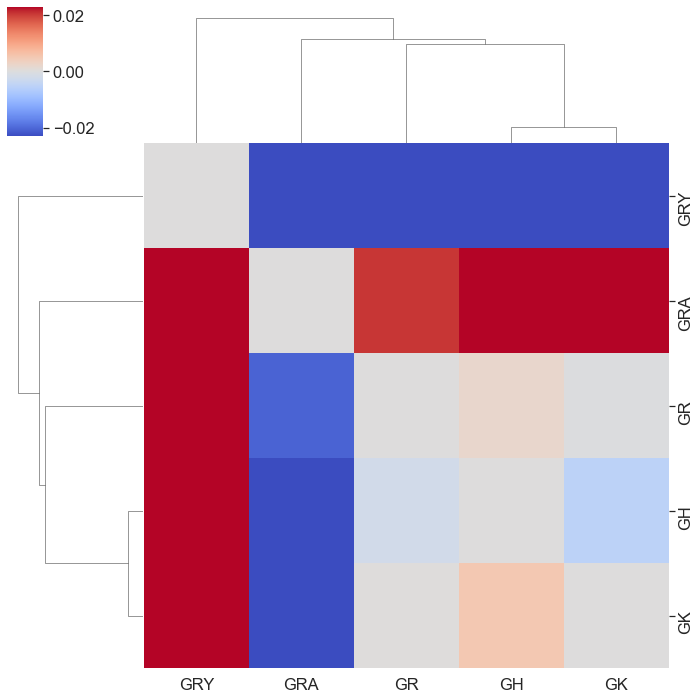

In [53]:
#Plot distance matrix as clustermap
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

#create distance array from distance matrix
distance_array = ssd.squareform(dist_mat) 

#create linkage object
distance_linkage = hierarchy.linkage(distance_array)

#display clustermap
g = sns.clustermap(dif_mat_sa, row_linkage=distance_linkage, col_linkage=distance_linkage,
               cmap = 'coolwarm',vmin=-.023,vmax=0.023)

Text(0.5, 1.0, 'GRA vs Clades Containing VOC')

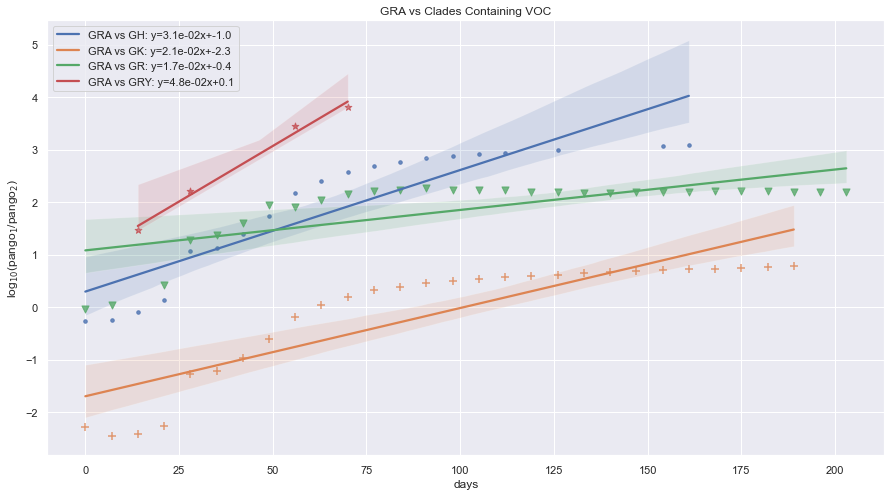

In [54]:
#scatterplot of GRA clade fitness
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
legend = []
marker = ['.', '+', 'v', 'x','*']
c=0
for i in clade_input:
    if i != 'GRA':
        mask = ~np.isnan(df_sa['days']) & ~np.isnan(df_sa['GRAvs{a}'.format(a=i)])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_sa['days'][mask],df_sa['GRAvs{a}'.format(a=i)][mask])
        sns.regplot(x = df_as['days'], y = df_as['GRAvs{a}'.format(a=i)], marker = marker[c],scatter_kws={'s':50})
        legend.append('GRA vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
    c+=1
plt.legend(legend, loc='upper left')
plt.ylabel(r'log$_1$$_0$(pango$_1$/pango$_2$)')
plt.title('GRA vs Clades Containing VOC')